In [1]:
from scapy.all import *
from pprint import pprint
import sys
import numpy as np
import os
import dpkt
import matplotlib.pyplot as plt

MAX_LINE_RATE =10e9


In [2]:
def read_pcap(out_dir, dst_mac_is_ts = True, try_compare_counters = True):
    
    if try_compare_counters:
        count_file = os.path.join(out_dir, 'counters_0.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                print("counters_0.out successfully opened")
                n_pkts_str = line.split()[-1]
                n_start_pkts = int(n_pkts_str[:-1])
        count_file = os.path.join(out_dir, 'counters_1.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                print("counters_1.out successfully opened")
                n_pkts_str = line.split()[-1]
                n_end_pkts = int(n_pkts_str[:-1])   
        n_expected_pkts = (n_end_pkts - n_start_pkts)
        
        print("Expecting {} packets".format(n_expected_pkts))
    
    
    pcf = os.path.join(out_dir, 'moongen', 'new_moongen.pcap')
    
    counters = {
        'ingress': 0,
        'egress': 0,
    }

    total_osize = 0
    total_isize = 0
    pkt_othroughput = []
    pkt_ithroughput = []
    pkt_ithroughput.append(1000)
    pkt_ithroughput.append(2000)
    pkt_othroughput.append(1000)
    pkt_othroughput.append(2000)
    
    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    
    for ts, buf in pcap:
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            ip=eth.data
            #print(ip.len)
            
            #TODO: Add a check to distinguish ingress and egress packets
            # If ingress, add to input array.
            # If egress, add to output array
            
            if eth.src == b'\x00\x00\x00\x00\x00\x02':
                counters['ingress'] += 1
            else:
                counters['egress'] += 1

            if dst_mac_is_ts:
                x3, x2, x1 = struct.unpack("!HHH", eth.dst)
                ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
                if eth.src == b'\x00\x00\x00\x00\x00\x01':
                    if ts <= pkt_othroughput[0]:
                        pkt_othroughput[0] = ts
                    pkt_othroughput[1] = ts
                    total_osize += ip.len + 14
                
                elif eth.src == b'\x00\x00\x00\x00\x00\x02':
                    if ts <= pkt_ithroughput[0]:
                        pkt_ithroughput[0] = ts
                    pkt_ithroughput[1] = ts  
                    total_isize += ip.len + 14

        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise
    
    print("Total input bytes: " + str(total_isize))
    print("Total output bytes: " + str(total_osize))
    print("Input throughput start, end: " + str(pkt_ithroughput))
    print("Output start, end " + str(pkt_othroughput))
    
    in_tput = ((total_isize * 8) / (pkt_ithroughput[1] - pkt_ithroughput[0]))
    out_tput = ((total_osize * 8) / (pkt_othroughput[1] - pkt_othroughput[0]))
    
    print("Input throughput " + str(in_tput))
    print("Output throughput " + str(out_tput))
    
    
    #return 1

In [3]:


def get_latency(out_dir, dst_mac_is_ts=True):
    
    pkt_latency = []
    pcf = os.path.join(out_dir, 'moongen', 'new_moongen.pcap')
    
    counters = {
        'ingress': 0,
        'egress': 0,
    }

    f = open(pcf, 'rb')
    
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    total_size = 0
    pkt_ingress = []
    pkt_egress = []
    
    
    for ts, buf in pcap:
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            
            #ip=eth.data
            
            #TODO: Add a check to distinguish ingress and egress packets
            # If ingress, add to input array.
            # If egress, add to output array
            
            if eth.src == b'\x00\x00\x00\x00\x00\x01':
                counters['egress'] += 1
            elif eth.src == b'\x00\x00\x00\x00\x00\x02':    
                counters['ingress'] += 1
            else:
                continue
            

            if dst_mac_is_ts:
                x3, x2, x1 = struct.unpack("!HHH", eth.dst)
                ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9
                
                if eth.src == b'\x00\x00\x00\x00\x00\x01':
                    pkt_egress.append(ts)
                elif eth.src == b'\x00\x00\x00\x00\x00\x02':    
                    pkt_ingress.append(ts)

                
        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise
     
    print("counters[ingress]" + str(counters['ingress']))
    print("counters[egress]" + str(counters['egress']))
    
    length = len(pkt_ingress)
    
    i = 0
    if length == 10000:
        while (i < length):
            pkt_latency.append(pkt_egress[i] - pkt_ingress[i])
            i += 1
        
    i = 0
    tot = 0
    
    print(len(pkt_latency))
    
    for val in pkt_latency:
        tot += val
    
    print(tot)
    print(length)
    avg = tot / length

    print(avg)
    
    plt.figure()
    plt.plot(pkt_latency,'.')

counters_0.out successfully opened
counters_1.out successfully opened
Expecting 20000 packets
Reading /home/ncshy/P4Boosters/testing/ufw/execution/test_output/ufw_200/ufw_200_13.00/moongen/new_moongen.pcap
Total input bytes: 10020000
Total output bytes: 10020000
Input throughput start, end: [41.733482797, 41.796969221000005]
Output start, end [41.733587399, 41.797009998]
Input throughput 1262632149.5127015
Output throughput 1263902792.7569041
Reading /home/ncshy/P4Boosters/testing/ufw/execution/test_output/ufw_200/ufw_200_13.00/moongen/new_moongen.pcap
counters[ingress]10000
counters[egress]10000
10000
0.3753101319998535
10000
3.753101319998535e-05


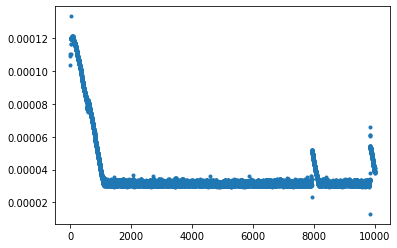

In [17]:
    out_dir = "/home/ncshy/P4Boosters/testing/ufw/execution/test_output/ufw_200/ufw_200_13.00"
#read_pcap_with_pkt(out_dir, True, True)
read_pcap(out_dir, True, True)
get_latency(out_dir, True)